In [1]:
import numpy as np
import pandas as pd
import re
import sys
from tqdm import tqdm
import time
import itertools
import matplotlib.pyplot as plt
import joblib
# Any results you write to the current directory are saved as output.
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Conv1D, MaxPooling1D,Input,CuDNNGRU, CuDNNLSTM,Bidirectional,GlobalAveragePooling1D,SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,TerminateOnNaN
from tensorflow.python.client import device_lib
from keras.optimizers import SGD

def config_GPU():
    def get_available_gpus():
        local_device_protos = device_lib.list_local_devices()
        return [x.name for x in local_device_protos if x.device_type == 'GPU']

    GPU_list = get_available_gpus()
    if len(GPU_list)>0:
        from keras import backend as K
        import tensorflow as tf
        from keras.backend.tensorflow_backend import set_session
        config = tf.ConfigProto()  
        config.gpu_options.allow_growth = True  
        config.gpu_options.per_process_gpu_memory_fraction = 0.99
        set_session(tf.Session(config=config)) 
        print('GPU configed')
    else:
        print('Do not found GPU')

Using TensorFlow backend.


In [2]:
emoji_dict = {'®': 'registered', '🙂': 'slightly smiling face', '™': 'trade mark', '©': 'copyright', '♥': 'heart suit', '😉': 'winking face', '😀': 'grinning face', '❤': 'red heart', '♦': 'diamond suit', '🙁': 'slightly frowning face', '😛': 'face with tongue', '▪': 'black small square', '✔': 'heavy check mark', '😦': 'frowning face with open mouth', '☺': 'smiling face', '😊': 'smiling face with smiling eyes', '▶': 'play button', '☎': 'telephone', '↩': 'right arrow curving left', '😂': 'face with tears of joy', '♀': 'female sign', '◼': 'black medium square', '😄': 'grinning face with smiling eyes', '😆': 'grinning squinting face', '😍': 'smiling face with heart-eyes', '✨': 'sparkles', '♠': 'spade suit', '✈': 'airplane', '👍': 'thumbs up', '♣': 'club suit', '↔': 'left-right arrow', '💕': 'two hearts', '♂': 'male sign', '😎': 'smiling face with sunglasses', '😃': 'grinning face with big eyes', '😁': 'beaming face with smiling eyes', '✖': 'heavy multiplication x', '😘': 'face blowing a kiss', '➡': 'right arrow', '◾': 'black medium-small square', '⬅': 'left arrow', '😜': 'winking face with tongue', '🙄': 'face with rolling eyes', '🔥': 'fire', '☀': 'sun', '✍': 'writing hand', '💖': 'sparkling heart', '💜': 'purple heart', '😳': 'flushed face', '😐': 'neutral face', '👌': 'OK hand', '✅': 'white heavy check mark', '💋': 'kiss mark', '✌': 'victory hand', '😕': 'confused face', '🎉': 'party popper', '💙': 'blue heart', '😮': 'face with open mouth', '😥': 'sad but relieved face', '💗': 'growing heart', '☮': 'peace symbol', '◀': 'reverse button', '😭': 'loudly crying face', '🙏': 'folded hands', '▫': 'white small square', '😢': 'crying face', '😋': 'face savoring food', '😯': 'hushed face', '🌟': 'glowing star', '😡': 'pouting face', '☑': 'ballot box with check', '🙌': 'raising hands', '🌸': 'cherry blossom', '👏': 'clapping hands', '🌹': 'rose', '☠': 'skull and crossbones', '😈': 'smiling face with horns', '🎶': 'musical notes', '😅': 'grinning face with sweat', '🤗': 'hugging face', '🤔': 'thinking face', '😏': 'smirking face', '📷': 'camera', '☯': 'yin yang', '😱': 'face screaming in fear', '⭐': 'white medium star', '💛': 'yellow heart', '💯': 'hundred points', '👀': 'eyes', '😝': 'squinting face with tongue', '🙈': 'see-no-evil monkey', '💚': 'green heart', '👑': 'crown', '😇': 'smiling face with halo', '😔': 'pensive face', '💪': 'flexed biceps', '😩': 'weary face', '✉': 'envelope', '💞': 'revolving hearts', '😬': 'grimacing face', '❄': 'snowflake', '↪': 'left arrow curving right', '👉': 'backhand index pointing right', '💥': 'collision', '😞': 'disappointed face', '🌺': 'hibiscus', '⚡': 'high voltage', '😒': 'unamused face', '🏆': 'trophy', '🌞': 'sun with face', '📸': 'camera with flash', '⚫': 'black circle', '🐝': 'honeybee', '📚': 'books', '🌴': 'palm tree', '🌈': 'rainbow', '💐': 'bouquet', '☂': 'umbrella', '🐶': 'dog face', '🌿': 'herb', '❣': 'heavy heart exclamation', '🌻': 'sunflower', '👊': 'oncoming fist', '💫': 'dizzy', '💓': 'beating heart', '✝': 'latin cross', '💡': 'light bulb', '👿': 'angry face with horns', '🎀': 'ribbon', '💔': 'broken heart', '☹': 'frowning face', '💘': 'heart with arrow', '🍀': 'four leaf clover', '🌷': 'tulip', '💎': 'gem stone', '❌': 'cross mark', '💦': 'sweat droplets', '🐾': 'paw prints', '↗': 'up-right arrow', '❗': 'exclamation mark', '☕': 'hot beverage', '🔁': 'repeat button', '😌': 'relieved face', '🎁': 'wrapped gift', '🎄': 'Christmas tree', '🤓': 'nerd face', '🎥': 'movie camera', '🎨': 'artist palette', '🙃': 'upside-down face', '🌎': 'globe showing Americas', '☁': 'cloud', '🌊': 'water wave', '❓': 'question mark', '☢': 'radioactive', '🍷': 'wine glass', '💝': 'heart with ribbon', '💃': 'woman dancing', '😑': 'expressionless face', '🍃': 'leaf fluttering in wind', '🔹': 'small blue diamond', '✡': 'star of David', '💰': 'money bag', '👻': 'ghost', '😻': 'smiling cat face with heart-eyes', '🎂': 'birthday cake', '💀': 'skull', '🍻': 'clinking beer mugs', '🎈': 'balloon', '🎤': 'microphone', '⚠': 'warning', '🦄': 'unicorn face', '🙊': 'speak-no-evil monkey', '☣': 'biohazard', '🚀': 'rocket', '🌼': 'blossom', '🖤': 'black heart', '👋': 'waving hand', '💩': 'pile of poo', '😲': 'astonished face', '💄': 'lipstick', '⚓': 'anchor', '🌱': 'seedling', '‼': 'double exclamation mark', '😣': 'persevering face', '😠': 'angry face', '↘': 'down-right arrow', '☃': 'snowman', '✴': 'eight-pointed star', '🍾': 'bottle with popping cork', '🤣': 'rolling on the floor laughing', '☝': 'index pointing up', '👎': 'thumbs down', '📱': 'mobile phone', '😫': 'tired face', '⚽': 'soccer ball', '😓': 'downcast face with sweat', '💟': 'heart decoration', '🚨': 'police car light', '✊': 'raised fist', '😚': 'kissing face with closed eyes', '🙋': 'person raising hand', '✂': 'scissors', '💍': 'ring', '🚗': 'automobile', '🌙': 'crescent moon', '👇': 'backhand index pointing down', '🔴': 'red circle', '🍕': 'pizza', '💁': 'person tipping hand', '😖': 'confounded face', '🌍': 'globe showing Europe-Africa', '😴': 'sleeping face', '⚜': 'fleur-de-lis', '🐱': 'cat face', '✋': 'raised hand', '🎵': 'musical note', '🎃': 'jack-o-lantern', '🎧': 'headphone', '🍹': 'tropical drink', '📖': 'open book', '🍓': 'strawberry', '🐰': 'rabbit face', '😤': 'face with steam from nose', '👙': 'bikini', '👯': 'people with bunny ears', '⭕': 'heavy large circle', '👽': 'alien', '🍸': 'cocktail glass', '🍴': 'fork and knife', '🍰': 'shortcake', '😙': 'kissing face with smiling eyes', '🤘': 'sign of the horns', '👈': 'backhand index pointing left', '🍦': 'soft ice cream', '🎼': 'musical score', '🌲': 'evergreen tree', '🍑': 'peach', '☄': 'comet', '🏃': 'person running', '🍎': 'red apple', '✒': 'black nib', '🎓': 'graduation cap', '🍁': 'maple leaf', '💻': 'laptop computer', '⬇': 'down arrow', '👗': 'dress', '🍺': 'beer mug', '🍔': 'hamburger', '👠': 'high-heeled shoe', '👅': 'tongue', '🏡': 'house with garden', '📍': 'round pushpin', '🦋': 'butterfly', '😨': 'fearful face', '😟': 'worried face', '🏈': 'american football', '🚫': 'prohibited', '😪': 'sleepy face', '📝': 'memo', '🐻': 'bear face', '🍒': 'cherries', '👆': 'backhand index pointing up', '🏀': 'basketball', '⏰': 'alarm clock', '💨': 'dashing away', '📺': 'television', '😰': 'anxious face with sweat', '🎸': 'guitar', '💅': 'nail polish', '🌏': 'globe showing Asia-Australia', '♏': 'Scorpio', '☘': 'shamrock', '🔸': 'small orange diamond', '✏': 'pencil', '😷': 'face with medical mask', '🎊': 'confetti ball', '💭': 'thought balloon', '🎬': 'clapper board', '👄': 'mouth', '♒': 'Aquarius', '🍫': 'chocolate bar', '🌳': 'deciduous tree', '🐣': 'hatching chick', '♨': 'hot springs', '🔮': 'crystal ball', '😵': 'dizzy face', '🌵': 'cactus', '🍭': 'lollipop', '💣': 'bomb', '♋': 'Cancer', '🍊': 'tangerine', '❕': 'white exclamation mark', '🍋': 'lemon', '😶': 'face without mouth', '🎅': 'Santa Claus', '☪': 'star and crescent', '🔫': 'pistol', '🥂': 'clinking glasses', '👟': 'running shoe', '⚔': 'crossed swords', '😧': 'anguished face', '👶': 'baby', '📌': 'pushpin', '🍌': 'banana', '🌅': 'sunrise', '😺': 'grinning cat face', '🌠': 'shooting star', '✳': 'eight-spoked asterisk', '👰': 'bride with veil', '🎆': 'fireworks', '💸': 'money with wings', '👸': 'princess', '💌': 'love letter', '🍪': 'cookie', '🍩': 'doughnut', '🏁': 'chequered flag', '🍍': 'pineapple', '🐟': 'fish', '👫': 'man and woman holding hands', '📲': 'mobile phone with arrow', '👼': 'baby angel', '🐸': 'frog face', '❇': 'sparkle', '❔': 'white question mark', '💬': 'speech balloon', '👩': 'woman', '🍉': 'watermelon', '🙆': 'person gesturing OK', '😸': 'grinning cat face with smiling eyes', '➕': 'heavy plus sign', '🍂': 'fallen leaf', '👣': 'footprints', '♍': 'Virgo', '🔊': 'speaker high volume', '🔑': 'key', '🍳': 'cooking', '⚾': 'baseball', '👭': 'two women holding hands', '💤': 'zzz', '🐷': 'pig face', '🐬': 'dolphin', '🐢': 'turtle', '⬆': 'up arrow', '↕': 'up-down arrow', '🎯': 'direct hit', '🐼': 'panda face', '🔵': 'blue circle', '🤖': 'robot face', '🐯': 'tiger face', '☔': 'umbrella with rain drops', '☸': 'wheel of dharma', '🙀': 'weary cat face', '♈': 'Aries', '📞': 'telephone receiver', '💵': 'dollar banknote', '🔶': 'large orange diamond', '😹': 'cat face with tears of joy', '💧': 'droplet', '🔝': 'TOP arrow', '🚴': 'person biking', '➖': 'heavy minus sign', '🐠': 'tropical fish', '👨': 'man', '🐙': 'octopus', '〰': 'wavy dash', '📽': 'film projector', '↙': 'down-left arrow', '🌾': 'sheaf of rice', '👁': 'eye', '🐥': 'front-facing baby chick', '⛄': 'snowman without snow', '💑': 'couple with heart', '♊': 'Gemini', '🙅': 'person gesturing NO', '🍆': 'eggplant', '🌀': 'cyclone', '🤤': 'drooling face', '🌌': 'milky way', '♌': 'Leo', '🐘': 'elephant', '◻': 'white medium square', '🎮': 'video game', '🔪': 'kitchen knife', '🏠': 'house', '🐦': 'bird', '⚪': 'white circle', '🐍': 'snake', '🌚': 'new moon face', '🗽': 'Statue of Liberty', '🏊': 'person swimming', '🐴': 'horse face', '♟': 'chess pawn', '📰': 'newspaper', '🦁': 'lion face', '🐕': 'dog', '🐞': 'lady beetle', '🏄': 'person surfing', '⤴': 'right arrow curving up', '🐳': 'spouting whale', '👹': 'ogre', '🏅': 'sports medal', '👧': 'girl', '🌐': 'globe with meridians', '🤑': 'money-mouth face', '💇': 'person getting haircut', '😗': 'kissing face', '🌮': 'taco', '♉': 'Taurus', '🎩': 'top hat', '🍗': 'poultry leg', '💉': 'syringe', '🙇': 'person bowing', '📹': 'video camera', '🐺': 'wolf face', '⚛': 'atom symbol', '💏': 'kiss', '👦': 'boy', '🍇': 'grapes', '🗣': 'speaking head', '♻': 'recycling symbol', '🍽': 'fork and knife with plate', '🔗': 'link', '🤞': 'crossed fingers', '🎭': 'performing arts', '🐇': 'rabbit', '🌶': 'hot pepper', '♎': 'Libra', '📢': 'loudspeaker', '♐': 'Sagittarius', '🏝': 'desert island', '🍼': 'baby bottle', '🐒': 'monkey', '👐': 'open hands', '🐈': 'cat', '♑': 'Capricorn', '🍏': 'green apple', '🖕': 'middle finger', '🐚': 'spiral shell', '🍬': 'candy', '♓': 'Pisces', '🚲': 'bicycle', '🕊': 'dove', '🐧': 'penguin', '🔺': 'red triangle pointed up', '⏩': 'fast-forward button', '🍅': 'tomato', '🎹': 'musical keyboard', '🍟': 'french fries', '🐎': 'horse', '⚙': 'gear', '🛍': 'shopping bags', '🚶': 'person walking', '🐐': 'goat', '🎾': 'tennis', '🔎': 'magnifying glass tilted right', '🏋': 'person lifting weights', '👾': 'alien monster', '➰': 'curly loop', '👪': 'family', '⌚': 'watch', '💆': 'person getting massage', '💊': 'pill', '🔍': 'magnifying glass tilted left', '🍵': 'teacup without handle', '🥀': 'wilted flower', '👜': 'handbag', '🍄': 'mushroom', '🍜': 'steaming bowl', '⚒': 'hammer and pick', '🍝': 'spaghetti', '🎙': 'studio microphone', '🍞': 'bread', '🚂': 'locomotive', '📦': 'package', '🌽': 'ear of corn', '🎇': 'sparkler', '🕺': 'man dancing', '🏖': 'beach with umbrella', '😼': 'cat face with wry smile', '🧀': 'cheese wedge', '👓': 'glasses', '🙉': 'hear-no-evil monkey', '🥑': 'avocado', '👕': 't-shirt', '⏳': 'hourglass not done', '😽': 'kissing cat face', '↖': 'up-left arrow', '🚙': 'sport utility vehicle', '📅': 'calendar', '🔨': 'hammer', '📻': 'radio', '🤙': 'call me hand', '🍨': 'ice cream', '🤐': 'zipper-mouth face', '🤦': 'person facepalming', '🐉': 'dragon', '🚘': 'oncoming automobile', '🔷': 'large blue diamond', '🐤': 'baby chick', '😿': 'crying cat face', '🌧': 'cloud with rain', '🎟': 'admission tickets', '🖖': 'vulcan salute', '🔒': 'locked', '👖': 'jeans', '⌨': 'keyboard', '💢': 'anger symbol', '💲': 'heavy dollar sign', '🌕': 'full moon', '🌛': 'first quarter moon face', '🕶': 'sunglasses', '📣': 'megaphone', '🤡': 'clown face', '🐵': 'monkey face', '🔘': 'radio button', '📈': 'chart increasing', '🤷': 'person shrugging', '🥇': '1st place medal', '⛵': 'sailboat', '👤': 'bust in silhouette', '📕': 'closed book', '🎣': 'fishing pole', '🆓': 'FREE button', '🌝': 'full moon face', '🍯': 'honey pot', '🌃': 'night with stars', '🆕': 'NEW button', '⌛': 'hourglass done', '🚽': 'toilet', '🐜': 'ant', '⛱': 'umbrella on ground', '🎻': 'violin', '🎺': 'trumpet', '🐑': 'ewe', '🦃': 'turkey', '📧': 'e-mail', '👮': 'police officer', '🤢': 'nauseated face', '🍣': 'sushi', '🐨': 'koala', '🍧': 'shaved ice', '👒': 'woman’s hat', '🌬': 'wind face', 'ℹ': 'information', '👛': 'purse', '👂': 'ear', '🐊': 'crocodile', '⚖': 'balance scale', '🤕': 'face with head-bandage', '⛰': 'mountain', '⏱': 'stopwatch', '🏉': 'rugby football', '👵': 'old woman', '◽': 'white medium-small square', '⛳': 'flag in hole', '🗡': 'dagger', '📡': 'satellite antenna', '👥': 'busts in silhouette', '⛈': 'cloud with lightning and rain', '🗺': 'world map', '🚌': 'bus', '🥃': 'tumbler glass', '🚩': 'triangular flag', '⛅': 'sun behind cloud', '🏔': 'snow-capped mountain', '⛷': 'skier', '☦': 'orthodox cross', '🗓': 'spiral calendar', '🏇': 'horse racing', '🗻': 'mount fuji', '🔜': 'SOON arrow', '🙍': 'person frowning', '🎲': 'game die', '💮': 'white flower', '👚': 'woman’s clothes', '🦅': 'eagle', '🐌': 'snail', '🔞': 'no one under eighteen', '⬛': 'black large square', '🤠': 'cowboy hat face', '🏍': 'motorcycle', '🌑': 'new moon', '🍤': 'fried shrimp', '👢': 'woman’s boot', '🖥': 'desktop computer', '🏌': 'person golfing', '🐋': 'whale', '🔱': 'trident emblem', '📘': 'blue book', '📓': 'notebook', '🦈': 'shark', '🌋': 'volcano', '💿': 'optical disk', '⁉': 'exclamation question mark', '📀': 'dvd', '👔': 'necktie', '🔋': 'battery', '🚚': 'delivery truck', '🏥': 'hospital', '🕵': 'detective', '🏫': 'school', '⬜': 'white large square', '🅰': 'A button (blood type)', '💳': 'credit card', '⛔': 'no entry', '🔐': 'locked with key', '🏢': 'office building', '📬': 'open mailbox with raised flag', '💒': 'wedding', '🌯': 'burrito', '🌪': 'tornado', '🎡': 'ferris wheel', '🚿': 'shower', '⚕': 'medical symbol', '🦉': 'owl', '🌨': 'cloud with snow', '🏞': 'national park', '📊': 'bar chart', '👡': 'woman’s sandal', '🐿': 'chipmunk', '🚁': 'helicopter', '🏙': 'cityscape', '🎢': 'roller coaster', '🚪': 'door', '🐂': 'ox', '🚑': 'ambulance', '🆒': 'COOL button', '⛓': 'chains', '🍡': 'dango', '📙': 'orange book', '📗': 'green book', '📄': 'page facing up', '👃': 'nose', '🌂': 'closed umbrella', '🤧': 'sneezing face', '🌰': 'chestnut', '🃏': 'joker', 'Ⓜ': 'circled M', '⏪': 'fast reverse button'}

In [3]:
d = {"can't":'can not'}
d.update(emoji_dict)
def multiple_replace(dic, text): 
    for k,v in dic.items():
        text = text.replace(k,v)
    return text

In [4]:
def preprocess(data): 
    def translate(w):
        #w = re.sub(r'[%()/\\[\]\":$#_\+“]+', " ", w)
        w = re.sub(r"[^a-zA-Z?.!,\*\-]+", " ", w)
        w = re.sub("([.,?!-])", r" \1 ", w)
        #w = re.sub(r'\*([a-z]+)\*',r'\1',w)
        
        #remove * which not like * in f**k
        w = re.sub(r'(?<=[a-z])\*\s',' ',w)
        w = re.sub(r'\s\*(?=[a-z])',' ',w)
        
        w = re.sub("'s(?= [\w\W]+)",'',w)
        w = re.sub("\'ll",' will',w)
        w = re.sub("'ve",' have',w)
        w = re.sub("'re",' are',w)
        w = re.sub("'m",' am',w)
        w = re.sub("n't",' not',w)
        w = re.sub("'d",' would',w)
        w = re.sub("'",'',w)  
        return w 
    print(translate(multiple_replace(d,"🙂This is% *so* cool). [It's\ like, 'would you+ \"want your mother to read this??' Really great idea, well done! i'll")))
    data = data.astype(str).apply(lambda x: translate(multiple_replace(d,x)))
    return data

In [5]:
def build_matrix(word_index, path):
    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    def load_embeddings(path):
        with open(path) as f:
            return dict(get_coefs(*line.strip().split(' ')) for line in f)
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

def auc_roc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def load_rnn_model(embedding_weights,max_sequence_length,summary = False):
    embedding_layer = Embedding(len(embedding_weights),
                            len(embedding_weights[0]),
                            weights=[embedding_weights],
                            input_length=max_sequence_length,
                            trainable=False)
    
    inp = Input(shape = (max_sequence_length,), dtype='int32')
    x = embedding_layer(inp)
    #x = SpatialDropout1D(0.5)(x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x) 
    #x = Conv1D(32, 3, activation='relu')(x)
    #x = MaxPooling1D(pool_size=3)(x)
    x = GlobalAveragePooling1D()(x)
    #x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    #x = Dropout(0.5)(x)
    rnn_output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=rnn_output)
    if summary:
        model.summary()
    return model

def train_model( X_train, y_train,model,epochs,class_weight = None):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.001)
    early_stop = EarlyStopping(monitor='auc_roc',patience=5,verbose=True,mode = 'max')
    model.compile(optimizer='Adadelta' ,loss='mean_squared_error',metrics = [auc_roc] )
    check_point = ModelCheckpoint('../rnn_model.hdf5',monitor='val_loss',
                                      verbose=False, save_best_only=True)
    history = model.fit(x = X_train, y = y_train,
                            batch_size = 512,
                            validation_split = 0.3,
                            epochs=epochs,
                            verbose = 0,
                            #class_weight = class_weight,
                            callbacks=[
                                early_stop,
                                check_point, reduce_lr,TerminateOnNaN()]
                 )
    scores = model.evaluate(X_train, y_train, verbose=0)
    print('\nEvalueation Score: {}\n'.format(scores))
    return scores,history.history,model

def plots_train(history):
        plt.figure(figsize =  (8,5))
        #plt.plot(d['quadratic_weighted_kappa'])
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.legend(['loss', 'val_loss'], loc='best')
        plt.show
        
        plt.figure(figsize =  (8,5))
        #plt.plot(d['quadratic_weighted_kappa'])
        plt.plot(history['auc_roc'])
        plt.plot(history['val_auc_roc'])
        plt.title('Model auc_roc')
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.legend(['auc_roc', 'val_auc_roc'], loc='best')
        plt.show

In [6]:
def main():
    config_GPU()
    nrows = None
    MAX_LEN = 200
    EPOCHS = 17
    time_dict = {}
    time_dict['start'] = time.time()

    #dataset
    print('lading data')
    train_path = "../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv"
    test_path = "../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv"
    train = pd.read_csv(train_path,usecols = ['id','comment_text','target'],nrows = nrows,dtype = {'id':np.int32})
    test = pd.read_csv(test_path,usecols = ['id','comment_text'],nrows = nrows,dtype = {'id':np.int32})
    from keras.preprocessing import text, sequence
    x_train = preprocess(train['comment_text'].str.lower())
    x_test = preprocess(test['comment_text'].str.lower())    
    
    y_train = (train['target'] > 0.5).astype(int).values
    submission = pd.DataFrame({'id': test['id'].values, 'prediction': 0})
    del train,test
    tokenizer = text.Tokenizer()
    tokenizer.fit_on_texts(list(x_train) + list(x_test))
    x_train = tokenizer.texts_to_sequences(x_train)
    x_test = tokenizer.texts_to_sequences(x_test)
    x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
    x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)
    time_dict['data'] = time.time()
    
    #embedding matrix
    print('loading weights')
    CRAWL_EMBEDDING_PATH = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
    GLOVE_EMBEDDING_PATH = '../input/glove840b300dtxt/glove.840B.300d.txt'
    crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
    print('n unknown words (crawl): ', len(unknown_words_crawl))
    glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
    del tokenizer
    print('n unknown words (glove): ', len(unknown_words_glove))
    embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
    print(len(unknown_words_crawl ),len(unknown_words_glove))
    del crawl_matrix,glove_matrix, unknown_words_crawl, unknown_words_glove
    embedding_matrix.shape
    time_dict['weight'] = time.time()
    
    
    #model & train
    print('training model')
    model = load_rnn_model(embedding_matrix,MAX_LEN,summary = False)
    del embedding_matrix
    scores,history,model = train_model(x_train, y_train,model,EPOCHS,class_weight = None)
    del x_train, y_train
    plots_train(history)
    time_dict['train'] = time.time()
    
    #predict 
    print('\n**Predicting data...**')
    submission['prediction'] = load_model('../rnn_model.hdf5',
                                      custom_objects={'auc_roc': auc_roc}).predict(x_test).reshape(len(x_test),)
    submission.to_csv('submission.csv', index=False)
    time_dict['predict'] = time.time()
    
    # time used
    print('\nTime Used (min):\n\n\data: {}\nweights: {}\
    \ntrain: {}\npredict: {}'.format(round((time_dict['data'] - time_dict['start'])/60,2),
                                       round((time_dict['weight'] - time_dict['data'])/60,2),
                                       round((time_dict['train'] - time_dict['weight'])/60,2),
                                       round((time_dict['predict'] - time_dict['train'])/60,2)))

GPU configed
lading data
slightly smiling faceThis is so cool  .  It s like ,  would you want your mother to read this ?  ?  Really great idea ,  well done !  i ll
slightly smiling faceThis is so cool  .  It s like ,  would you want your mother to read this ?  ?  Really great idea ,  well done !  i ll
loading weights
n unknown words (crawl):  146329
n unknown words (glove):  142982
146329 142982
training model

Evalueation Score: [0.025008227473185023, 0.9586598300438157]


**Predicting data...**

Time Used (min):

\data: 8.84
weights: 4.71    
train: 105.79
predict: 0.7


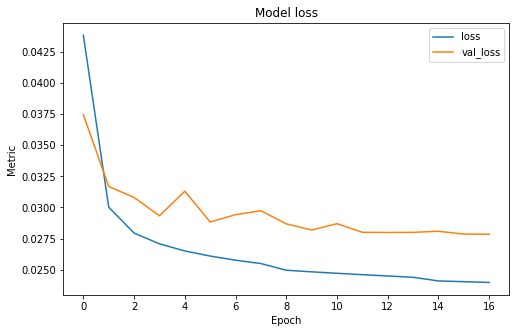

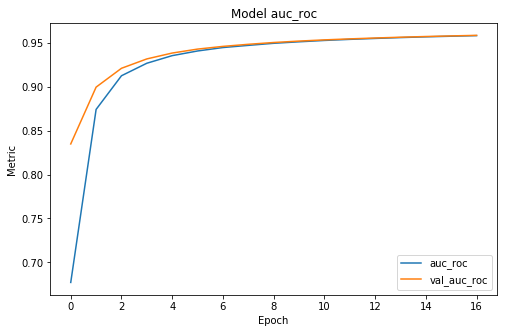

In [7]:
if __name__ == "__main__":
    main()